## Testing hypothesis 7
---

**_Hypothesis_**: Publishers are very specialized, so no publisher are able to get high scores (> 4.5) in more than 10 categories.

   - **Metric**: N. of times a publisher gets a score > 4.5 in different categories.
    
**Missing Values**:
  
- `publisher`: remove the entire sample
- `review/score`: remove the entire sample
- `categories`: remove the entire sample

**Data Transformation**:

- `categories`: GroupBy categories.
- `publisher`: GroupBy publisher.
- `review/score`: Compute the average review/score for each publisher.

---

In [1]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_hypothesis_7']

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':{
                                     'category':'$categories',
                                     'publisher':'$publisher',
                                     },
                                'avg_score':{'$avg':'$review/score'},
                                'count':{'$sum':1}
                                }
                           }

# Show average rating for category for each publisher
pipeline_publisher = {'$group': {
               '_id': '$_id.publisher',
               'avg_score/category': {
                    '$push': {
                         'category': '$_id.category',
                         'avg_score': '$avg_score',
                         'count': '$count'
                         }
                    }
               }
          }

# Unwind the list of categories
pipeline_unwind = {'$unwind':'$avg_score/category'}

# Remove categories or publisher with less than 'threshold' reviews
threshold = 0
pipeline_remove = {'$match':{
                         'avg_score/category.count':{'$gte':threshold}
                         }
                }

# Count the number of categories with average rating > 4.5
pipeline_counts = {'$project': {
                         'publisher': '$_id',
                         '_id':0,
                         'category':'$avg_score/category.category',
                         'count': {
                              '$sum': {
                                   '$cond': {
                                   
                                        'if':{'$gt': ['$avg_score/category.avg_score', 4.5]},
                                        'then':1,
                                        'else':0
                                   }
                              }
                         }
                    }
               }

# Sum the results for each publisher. If Total > 10, then the hypothesis is False
pipeline_sum = {'$group': {
                    '_id': '$publisher', 
                    'total': {'$sum': '$count'}
                    }
                }

pipeline_sort = {'$sort':{
                         'total':-1
                         }
                }

results = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_publisher, pipeline_unwind, pipeline_remove, pipeline_counts, pipeline_sum, pipeline_sort])

df_results = pd.DataFrame(list(results))

In [16]:
df_results.head()

,_id,total
0,Random House,31
1,Oxford University Press USA,30
2,Vintage,23
3,Lulu com,20
4,Prentice Hall,19


<AxesSubplot: title={'center': 'Number of categories with average rating > 4.5 for each publisher'}, xlabel='publisher'>

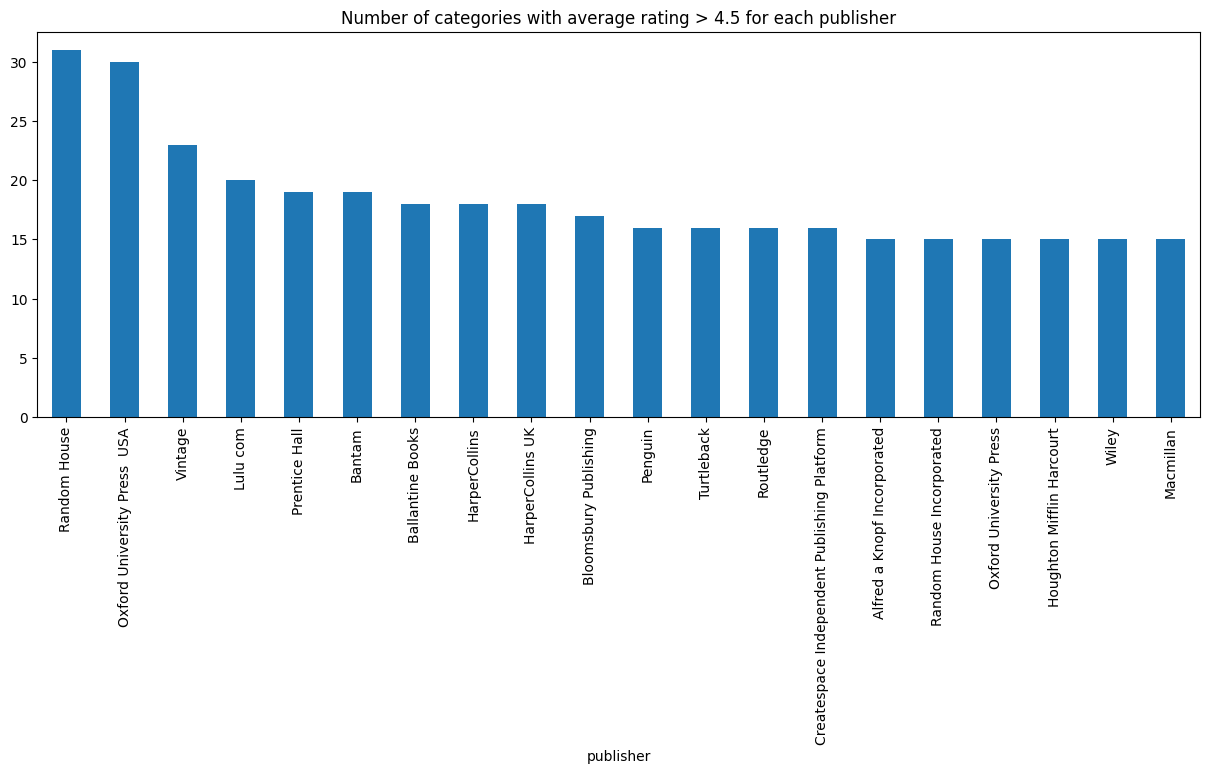

In [17]:
df_results.head(20).plot(x='_id', y='total', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Number of categories with average rating > 4.5 for each publisher', legend=False)

## Deeper analysis focused on categories and publishers separately
---

### Analysis of categories

In [23]:
# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':'$categories',
                                'avg_score':{'$avg':'$review/score'},
                                'count':{'$sum':1},
                                'titles':{'$addToSet':'$Title'}
                                }
                           }


pipeline_project = {'$project':{
                         '_id':0,
                         'category':'$_id',
                         'avg_score':1,
                         'count': 1,
                         'num_titles':{'$size':'$titles'}
                         }
                    }

pipeline_remove = {'$match':{
                         'count':{'$gt':100}
                              }  
                    }

results_2 = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2_category = pd.DataFrame(list(results_2))
df_results_2_category['avg_score_weighted'] = df_results_2_category.avg_score*np.sqrt(df_results_2_category.num_titles)

In [24]:
df_results_2_category.sort_values(by='num_titles', ascending = False).head()

,avg_score,count,category,num_titles,avg_score_weighted
35,4.111363,66512,Fiction,10424,419.761944
63,4.335915,7618,Religion,2776,228.449643
45,4.457071,16201,Juvenile Fiction,2664,230.047024
41,4.255105,7052,History,2631,218.258265
12,4.246247,8394,Biography Autobiography,2293,203.332740


<AxesSubplot: title={'center': 'Number of reviews for each category'}, xlabel='category'>

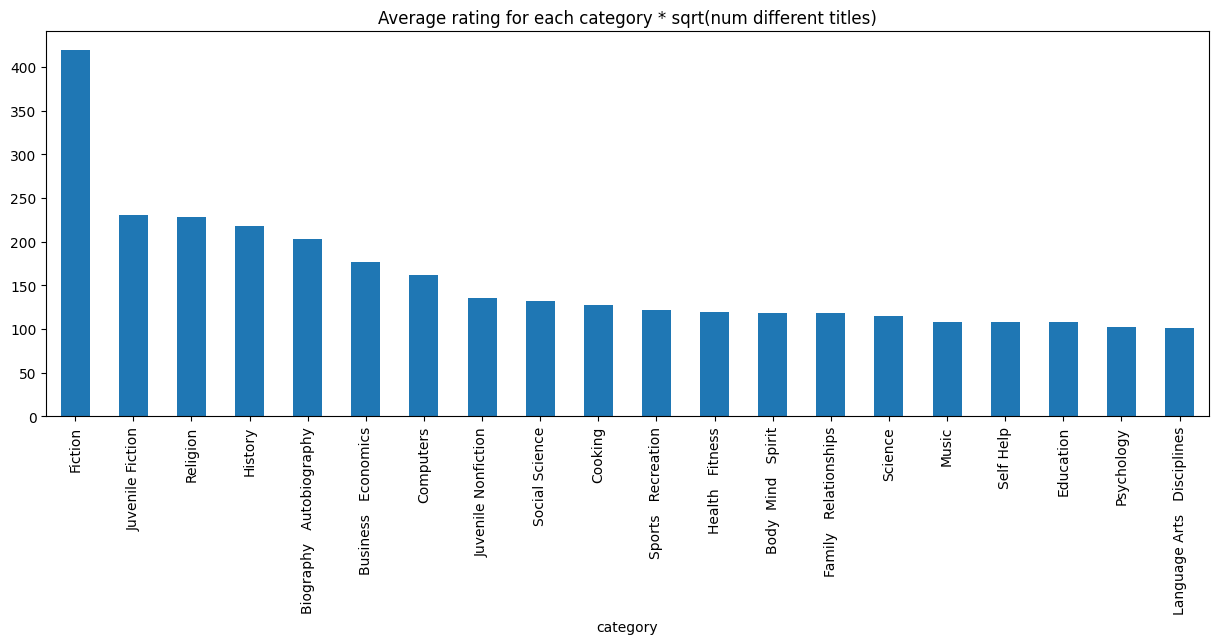

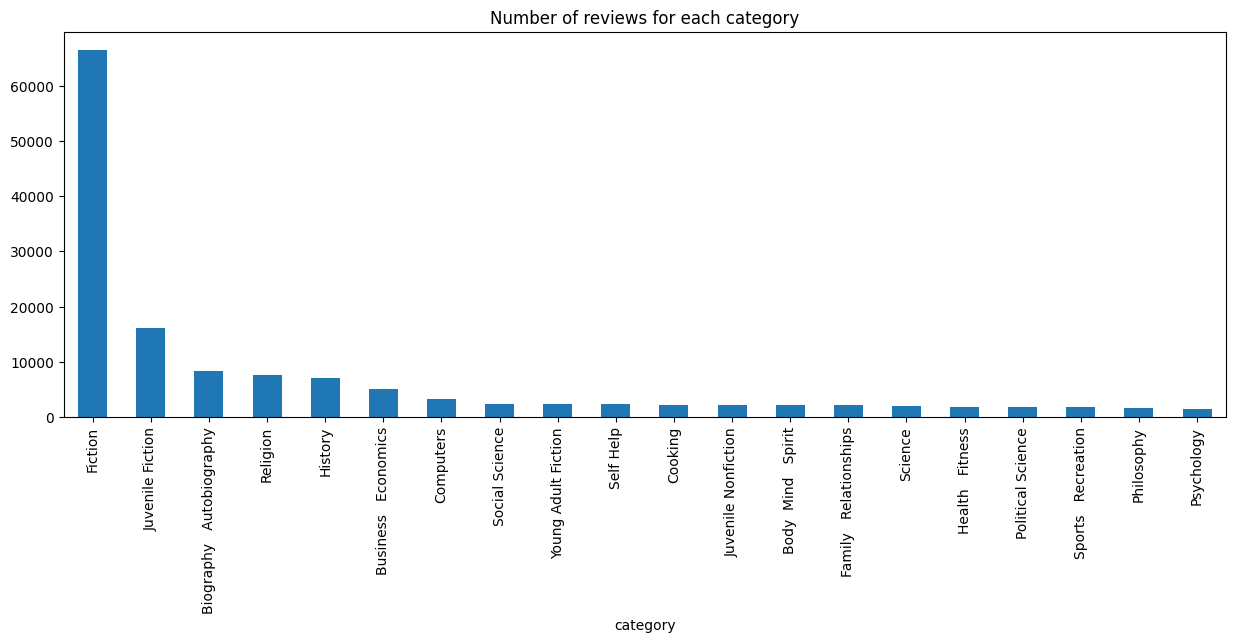

In [26]:
# Analyze the top 20 categories with the highest average rating
df_results_2_category.sort_values(by='avg_score_weighted', ascending = False, inplace=True)
df_results_2_category.head(20).plot(x='category', y='avg_score_weighted', kind='bar', figsize=(15,5), xlabel = 'category', title='Average rating for each category * sqrt(num different titles)', legend=False)

# Analyze the top 20 categories with the highest number of reviews
df_results_2_category.sort_values(by='count', ascending = False, inplace=True)
df_results_2_category.head(20).plot(x='category', y='count', kind='bar', figsize=(15,5), xlabel = 'category', title='Number of reviews for each category', legend=False)

### Analysis of publishers

In [27]:
# Deal with missing values
pipeline_missing = {'$match':{
                         'review/score':{'$exists':True, '$ne':0.0},
                         'publisher':{'$exists':True, '$ne':None},
                         'categories':{'$exists':True},
                              }  
                    }    

# Compute average rating for each tuple category, publisher
pipeline_average_rating = {'$group':{
                                '_id':'$publisher',
                                'avg_score':{'$avg':'$review/score'},
                                'count':{'$sum':1},
                                'titles':{'$addToSet':'$Title'}
                                }
                           }

pipeline_project = {'$project':{
                         '_id':0,
                         'publisher':'$_id',
                         'avg_score':1,
                         'count': 1,
                         'num_titles':{'$size':'$titles'}
                         }
                    }

pipeline_remove = {'$match':{
                         'count':{'$gt':100}
                              }  
                    }

results_2 = books.aggregate([pipeline_missing, pipeline_average_rating, pipeline_project, pipeline_remove])

df_results_2_publisher = pd.DataFrame(list(results_2))
df_results_2_publisher['avg_score_weighted'] = df_results_2_publisher.avg_score*np.sqrt(df_results_2_publisher.num_titles)

In [28]:
df_results_2_publisher.head()

,avg_score,count,publisher,num_titles,avg_score_weighted
0,4.155251,219,A C Black,96,40.712980
1,4.084746,118,Abrams,36,24.508475
2,4.300469,213,Addison Wesley Professional,98,42.572476
3,4.584158,101,Aladdin,19,19.981883
4,4.033557,149,Alfred a Knopf Incorporated,41,25.827367


<AxesSubplot: title={'center': 'Number of reviews for each publisher'}, xlabel='publisher'>

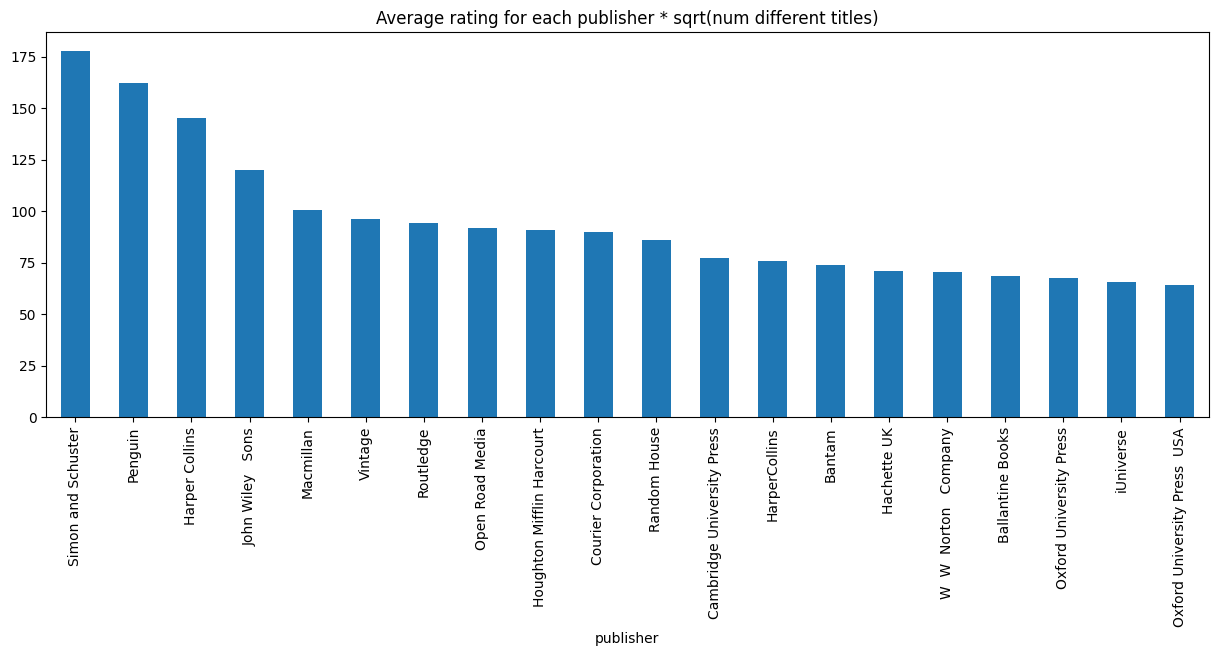

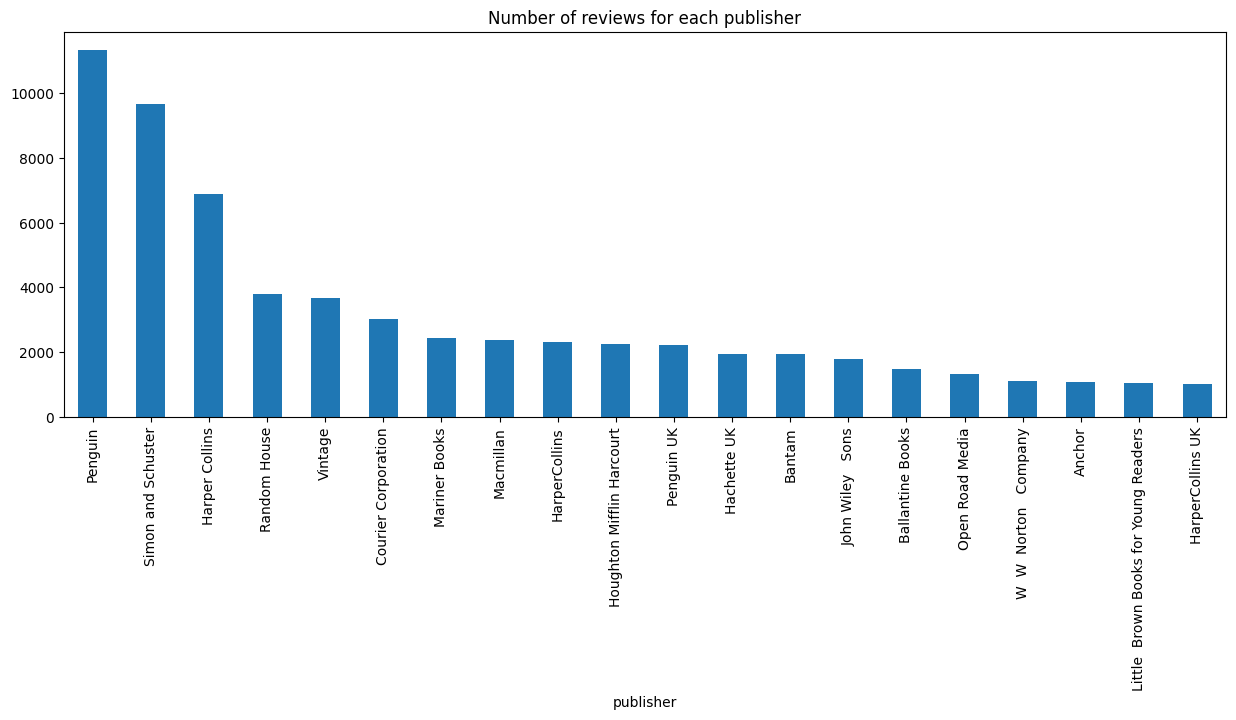

In [29]:
# Analyze the top 20 publishers with the highest average rating
df_results_2_publisher.sort_values(by='avg_score_weighted', ascending = False, inplace=True)
df_results_2_publisher.head(20).plot(x='publisher', y='avg_score_weighted', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Average rating for each publisher * sqrt(num different titles)', legend=False)

# Analyze the top 20 publishers with the highest number of reviews
df_results_2_publisher.sort_values(by='count', ascending = False, inplace=True)
df_results_2_publisher.head(20).plot(x='publisher', y='count', kind='bar', figsize=(15,5), xlabel = 'publisher', title='Number of reviews for each publisher', legend=False)

## Correlation between avg_score and number of different titles published

---

In [ ]:
# avg_score for category respect to number of different titles
df_results_2_category.head(50).plot(x='num_titles', y='avg_score', kind='scatter', figsize=(15,5), xlabel = 'num_titles', title='Average rating for each category respect to number of different titles', legend=False)

In [34]:
import scipy.stats as stats

# Check if the data are normally distributed
score_ntest, p_value_score_ntest = stats.normaltest(df_results_2_category['num_titles'])
help_ntest, p_value_help_ntest = stats.normaltest(df_results_2_category['avg_score'])

# Print the conclusion
if p_value_score_ntest < 0.05:
    print(f"The p-value for normality test of num_titles is {p_value_score_ntest}. The data is not normally distributed.")
else:
    print(f"The p-value for normality test of num_titles is {p_value_score_ntest}. The data is normally distributed.")

if p_value_help_ntest < 0.05:
    print(f"The p-value for normality test of avg_score is {p_value_help_ntest}. The data is not normally distributed.")
else:
    print(f"The p-value for normality test of avg_score is {p_value_help_ntest}. The data is normally distributed.")
    
# Check the correlation between the two variables
person_coeff, p_value_corr = stats.spearmanr(df_results_2_category['num_titles'], df_results_2_category['avg_score'])

# Print the conclusion
if p_value_corr < 0.05:
    print(f"The p-value for correlation between num_titles and avg_score is {p_value_corr}. The correlation is not significant.")
else:
    print(f"The p-value for correlation between num_titles and avg_score is {p_value_corr}. The correlation is significant.")
    
# Check if the two variables follow same distribution
ks_stat, p_value_ks = stats.ks_2samp(df_results_2_category['num_titles'], df_results_2_category['avg_score'])

# Print the conclusion
if p_value_ks < 0.05:
    print(f"The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is {p_value_ks}. The two variables do not follow the same distribution.")
else:
    print(f"The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is {p_value_ks}. The two variables follow the same distribution.")
    
# Check if the two variables are independent
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(pd.crosstab(df_results_2_category['num_titles'], df_results_2_category['avg_score']))

# Print the conclusion
if p_value_chi2 < 0.05:
    print(f"The p-value for Chi-Square test between num_titles and avg_score is {p_value_chi2}. The two variables are not independent.")
else:
    print(f"The p-value for Chi-Square test between num_titles and avg_score is {p_value_chi2}. The two variables are independent.")

# Check if the mean of the two variables are equal using Wilcoxon
wilcoxon_stat, p_value_wilcoxon = stats.wilcoxon(df_results_2_category['num_titles'], df_results_2_category['avg_score'])

# Print the conclusion
if p_value_wilcoxon < 0.05:
    print(f"The p-value for Wilcoxon test between num_titles and avg_score is {p_value_wilcoxon}. The two variables do not have the same mean.")
else:
    print(f"The p-value for Wilcoxon test between num_titles and avg_score is {p_value_wilcoxon}. The two variables have the same mean.")

The p-value for normality test of num_titles is 1.5776346970288913e-29. The data is not normally distributed.
The p-value for normality test of avg_score is 0.7276210777627938. The data is normally distributed.
The p-value for correlation between num_titles and avg_score is 0.9959785502892587. The correlation is significant.
The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is 5.0835150341972324e-31. The two variables do not follow the same distribution.
The p-value for Chi-Square test between num_titles and avg_score is 0.2492268701391572. The two variables are independent.
The p-value for Wilcoxon test between num_titles and avg_score is 6.415716534492213e-13. The two variables do not have the same mean.


<AxesSubplot: title={'center': 'Average rating for each publisher respect to number of different titles'}, xlabel='num_titles', ylabel='avg_score'>

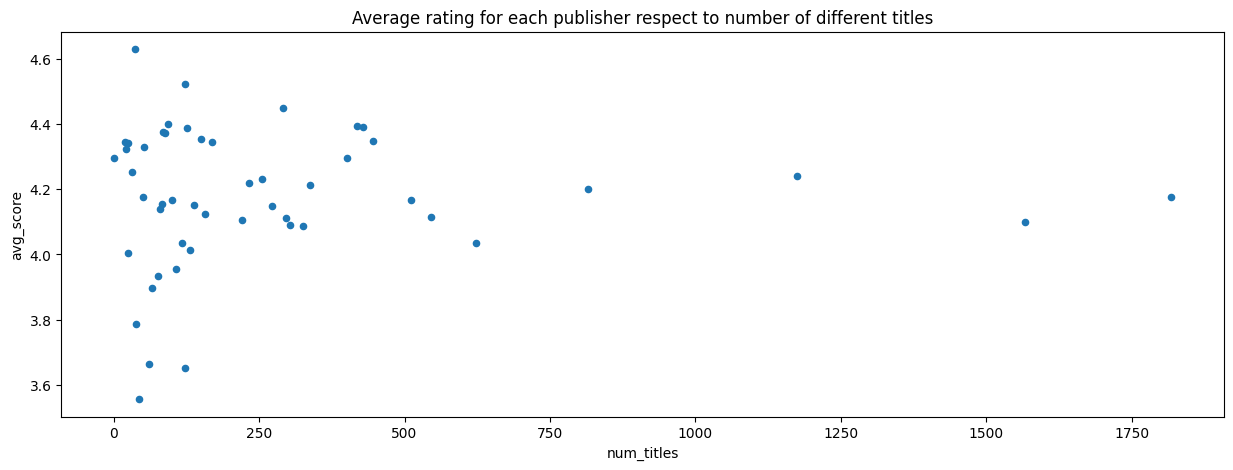

In [35]:
# avg_score for publisher respect to number of different titles
df_results_2_publisher.head(50).plot(x='num_titles', y='avg_score', kind='scatter', figsize=(15,5), xlabel = 'num_titles', title='Average rating for each publisher respect to number of different titles', legend=False)

In [36]:
import scipy.stats as stats

# Check if the data are normally distributed
score_ntest, p_value_score_ntest = stats.normaltest(df_results_2_publisher['num_titles'])
help_ntest, p_value_help_ntest = stats.normaltest(df_results_2_publisher['avg_score'])

# Print the conclusion
if p_value_score_ntest < 0.05:
    print(f"The p-value for normality test of num_titles is {p_value_score_ntest}. The data is not normally distributed.")
else:
    print(f"The p-value for normality test of num_titles is {p_value_score_ntest}. The data is normally distributed.")

if p_value_help_ntest < 0.05:
    print(f"The p-value for normality test of avg_score is {p_value_help_ntest}. The data is not normally distributed.")
else:
    print(f"The p-value for normality test of avg_score is {p_value_help_ntest}. The data is normally distributed.")
    
# Check the correlation between the two variables
person_coeff, p_value_corr = stats.spearmanr(df_results_2_publisher['num_titles'], df_results_2_publisher['avg_score'])

# Print the conclusion
if p_value_corr < 0.05:
    print(f"The p-value for correlation between num_titles and avg_score is {p_value_corr}. The correlation is not significant.")
else:
    print(f"The p-value for correlation between num_titles and avg_score is {p_value_corr}. The correlation is significant.")
    
# Check if the two variables follow same distribution
ks_stat, p_value_ks = stats.ks_2samp(df_results_2_publisher['num_titles'], df_results_2_publisher['avg_score'])

# Print the conclusion
if p_value_ks < 0.05:
    print(f"The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is {p_value_ks}. The two variables do not follow the same distribution.")
else:
    print(f"The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is {p_value_ks}. The two variables follow the same distribution.")
    
# Check if the two variables are independent
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(pd.crosstab(df_results_2_publisher['num_titles'], df_results_2_publisher['avg_score']))

# Print the conclusion
if p_value_chi2 < 0.05:
    print(f"The p-value for Chi-Square test between num_titles and avg_score is {p_value_chi2}. The two variables are not independent.")
else:
    print(f"The p-value for Chi-Square test between num_titles and avg_score is {p_value_chi2}. The two variables are independent.")

# Check if the mean of the two variables are equal using Wilcoxon
wilcoxon_stat, p_value_wilcoxon = stats.wilcoxon(df_results_2_publisher['num_titles'], df_results_2_publisher['avg_score'])

# Print the conclusion
if p_value_wilcoxon < 0.05:
    print(f"The p-value for Wilcoxon test between num_titles and avg_score is {p_value_wilcoxon}. The two variables do not have the same mean.")
else:
    print(f"The p-value for Wilcoxon test between num_titles and avg_score is {p_value_wilcoxon}. The two variables have the same mean.")

The p-value for normality test of num_titles is 1.1730348745498185e-75. The data is not normally distributed.
The p-value for normality test of avg_score is 1.1394446646277324e-26. The data is not normally distributed.
The p-value for correlation between num_titles and avg_score is 0.14980143236590235. The correlation is significant.
The p-value for Kolmogorov-Smirnov test between num_titles and avg_score is 6.399746963322389e-119. The two variables do not follow the same distribution.
The p-value for Chi-Square test between num_titles and avg_score is 0.20661699863649663. The two variables are independent.
The p-value for Wilcoxon test between num_titles and avg_score is 6.788765638653643e-43. The two variables do not have the same mean.
